### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

#### Решение задания 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [3]:
class Config:
    pass

config_1 = Config()
config_1.mnist_path = None
config_1.batch_size = 64
config_1.num_workers = 3
config_1.num_epochs = 30
config_1.noise_size = 100
config_1.print_freq = 100
config_1.clip_value = 0.01


In [4]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [5]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [6]:
len(dataloader)

3750

In [7]:
for image, cat in dataloader:
    break

In [8]:
image.size()

torch.Size([16, 1, 28, 28])

In [9]:
28*28

784

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config_1.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
    def forward(self, x):
        return self.model(x)

In [11]:
generator_1 = Generator()
discriminator_1 = Discriminator()

In [12]:
optim_G = optim.Adam(params=generator_1.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator_1.parameters(), lr=0.0001)

In [13]:
noise = Variable(torch.FloatTensor(config_1.batch_size, config_1.noise_size))
fixed_noise = Variable(torch.FloatTensor(config_1.batch_size, config_1.noise_size).normal_(0, 1))

In [14]:
# для хранения значений loss
ERRD_real_1 = np.zeros(config_1.num_epochs)
ERRD_fake_1 = np.zeros(config_1.num_epochs)
ERRG_1 = np.zeros(config_1.num_epochs)
N = len(dataloader)

for epoch in range(config_1.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize L = E[D(fake)] - E[D(real)]
        #######

        discriminator_1.zero_grad()
        
        # реальные изображения
        real_data = images.view(images.shape[0], -1)
        
        # forward pass реальных изображений
        D_real = discriminator_1(real_data)
        
        # генерируются фейковые изображения
        noise.data.normal_(0, 1)
        fake = generator_1(noise)
        
        # forward pass фейковых изображений
        D_fake = discriminator_1(fake.detach())
        
        # loss дискриминатора для WGAN: L = E[D(fake)] - E[D(real)]
        errD = torch.mean(D_fake) - torch.mean(D_real)
        ERRD_fake_1[epoch] += torch.mean(D_fake).item()
        ERRD_real_1[epoch] += torch.mean(D_real).item()
        
        errD.backward()
        
        # обновление весов дискриминатора
        optim_D.step()

        # weight clipping для дискриминатора
        for p in discriminator_1.parameters():
            p.data.clamp_(-config_1.clip_value, config_1.clip_value)
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######

        # обновление генератора каждые n_critic шагов
        n_critic = 5

        if iteration % n_critic == 0:
            generator_1.zero_grad()

            # генерация новых фейковых изображений
            noise.data.normal_(0, 1)
            fake = generator_1(noise)
            
            # forward pass фейков через дискриминатор
            D_fake = discriminator_1(fake)
            
            # loss генератора для WGAN: -E[D(fake)] 
            errG = -torch.mean(D_fake)
            ERRG_1[epoch] += errG.item()

            errG.backward()
        
            # обновление весов генератора
            optim_G.step()
        
        # вывод статистики
        if (iteration+1) % config_1.print_freq == 0:
            print(f'Epoch: {epoch+1}/{config_1.num_epochs} '
                  f'Iter: {iteration+1} '
                  f'D_loss: {errD.item():.4f} '
                  f'G_loss: {errG.item() if "errG" in locals() else 0:.4f} '
                  f'D(real): {torch.mean(D_real).item():.4f} '
                  f'D(fake): {torch.mean(D_fake).item():.4f}')

Epoch: 1/30 Iter: 100 D_loss: -0.1072 G_loss: 0.0422 D(real): 0.0624 D(fake): -0.0448
Epoch: 1/30 Iter: 200 D_loss: -0.4181 G_loss: 0.1430 D(real): 0.2750 D(fake): -0.1432
Epoch: 1/30 Iter: 300 D_loss: -0.6244 G_loss: 0.1609 D(real): 0.4675 D(fake): -0.1569
Epoch: 1/30 Iter: 400 D_loss: -0.5313 G_loss: 0.1468 D(real): 0.3850 D(fake): -0.1463
Epoch: 1/30 Iter: 500 D_loss: -0.4096 G_loss: 0.1488 D(real): 0.2630 D(fake): -0.1466
Epoch: 1/30 Iter: 600 D_loss: -0.3807 G_loss: 0.1414 D(real): 0.2604 D(fake): -0.1203
Epoch: 1/30 Iter: 700 D_loss: -0.2725 G_loss: 0.1424 D(real): 0.1386 D(fake): -0.1339
Epoch: 1/30 Iter: 800 D_loss: -0.2715 G_loss: 0.1346 D(real): 0.1489 D(fake): -0.1226
Epoch: 1/30 Iter: 900 D_loss: -0.2368 G_loss: 0.1316 D(real): 0.1018 D(fake): -0.1350
Epoch: 1/30 Iter: 1000 D_loss: -0.2867 G_loss: 0.1370 D(real): 0.1454 D(fake): -0.1413
Epoch: 1/30 Iter: 1100 D_loss: -0.2373 G_loss: 0.1579 D(real): 0.0755 D(fake): -0.1618
Epoch: 1/30 Iter: 1200 D_loss: -0.2556 G_loss: 0.168

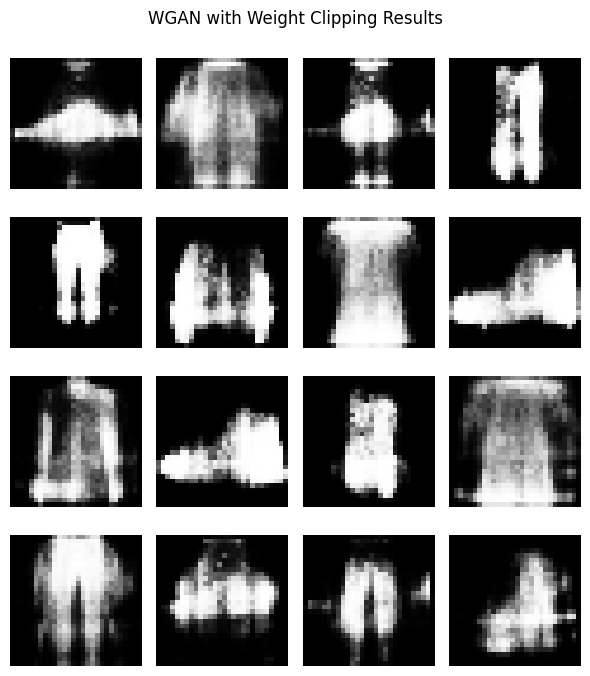

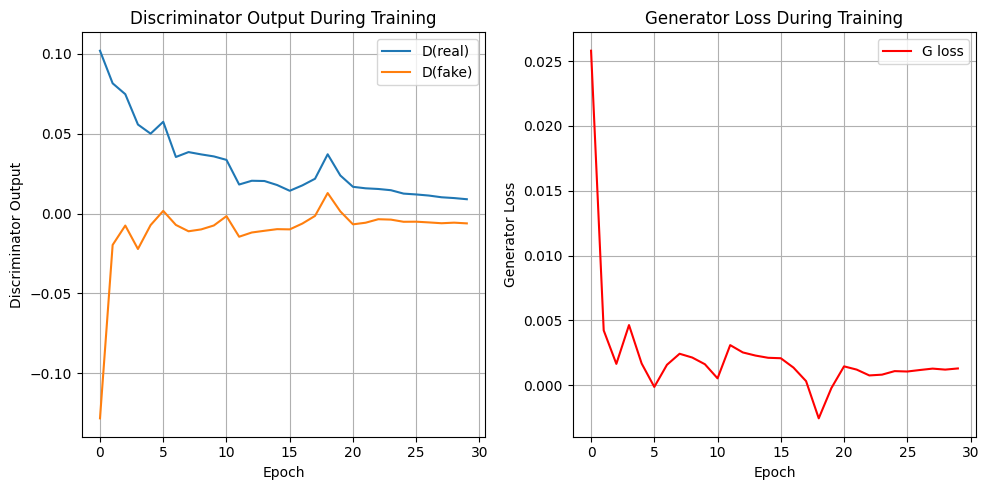

In [15]:
# визуализация результатов
noise.data.normal_(0, 1)
fake = generator_1(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.suptitle('WGAN with Weight Clipping Results')
plt.tight_layout()
plt.show()

# График loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ERRD_real_1 / N, label='D(real)')
plt.plot(ERRD_fake_1 / N, label='D(fake)')
plt.xlabel('Epoch')
plt.ylabel('Discriminator Output')
plt.title('Discriminator Output During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ERRG_1 / N, label='G loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss During Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Что было сделано:

Реализована классическая архитектура Wasserstein GAN с использованием weight clipping для ограничения весов дискриминатора. Обучение проводилось на датасете FashionMNIST в течение 30 эпох.

#### Использовались:

Полносвязные сети для генератора и дискриминатора.

Оптимизатор Adam с learning rate = 0.0001.

Веса дискриминатора обрезались до значения clip_value = 0.01.

#### Результаты:

Генератор постепенно улучшается, о чём говорит уменьшение G_loss.

Визуально сгенерированные изображения становятся узнаваемыми (одежда, обувь), но остаются размытыми и нечёткими. Поэтому была предпринята попытка улучшить результаты за счёт перехода от начальных параметров (batch_size=16, num_epochs=10, noise_size=50) к новым (batch_size=64, num_epochs=30, noise_size=100), что немного повысило качество результатов.

#### Выводы:

Weight clipping помогает стабилизировать обучение GAN, но качество картинок не идеальное.

#### Решение задания 2

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [26]:
class Config:
    pass

config_2 = Config()
config_2.mnist_path = None
config_2.batch_size = 16
config_2.num_workers = 3
config_2.num_epochs = 10
config_2.noise_size = 50
config_2.print_freq = 100
config_2.lambda_gp = 10  # коэффициент для gradient penalty
config_2.n_critic = 5

In [27]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(train, batch_size=config_2.batch_size, shuffle=True)

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config_2.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))

    def forward(self, x):
        return self.model(x)

In [29]:
generator_2 = Generator()
discriminator_2 = Discriminator()

In [30]:
optim_G = optim.Adam(generator_2.parameters(), lr=0.0001)
optim_D = optim.Adam(discriminator_2.parameters(), lr=0.0001)

In [31]:
noise = Variable(torch.FloatTensor(config_2.batch_size, config_2.noise_size))
fixed_noise = Variable(torch.FloatTensor(config_2.batch_size, config_2.noise_size).normal_(0, 1))

In [32]:
# для вычисления gradient penalty
def compute_gradient_penalty(discriminator_2, real_samples, fake_samples):
    # cлучайный вес для интерполяции
    alpha = torch.rand(real_samples.size(0), 1)
    alpha = alpha.expand(real_samples.size())
    
    # интерполяция между реальными и сгенерированными samples
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated = Variable(interpolated, requires_grad=True)
    
    d_interpolated = discriminator_2(interpolated)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients_norm = gradients.norm(2, dim=1)
    
    # gradient penalty = (||grad||_2 - 1)^2
    gradient_penalty = ((gradients_norm - 1) ** 2).mean()
    
    return gradient_penalty

In [33]:
# для хранения значений loss
ERRD_real_2 = np.zeros(config_2.num_epochs)
ERRD_fake_2 = np.zeros(config_2.num_epochs)
ERRG_2 = np.zeros(config_2.num_epochs)
N = len(dataloader)

for epoch in range(config_2.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize L = E[D(fake)] - E[D(real)]
        #######

        discriminator_2.zero_grad()
        
        # реальные изображения
        real_data = images.view(images.shape[0], -1)
        
        # forward pass реальных изображений
        D_real = discriminator_2(real_data)
        
        # генерируются фейковые изображения
        noise.data.normal_(0, 1)
        fake = generator_2(noise)

        # forward pass фейковых изображений
        D_fake = discriminator_2(fake.detach())
        
        gradient_penalty = compute_gradient_penalty(discriminator_2, real_data.data, fake.data)
        
        # loss дискриминатора для WGAN: L = E[D(fake)] - E[D(real)] + lambda * GP
        errD = torch.mean(D_fake) - torch.mean(D_real) + config_2.lambda_gp * gradient_penalty
        ERRD_fake_2[epoch] += torch.mean(D_fake).item()
        ERRD_real_2[epoch] += torch.mean(D_real).item()
        
        errD.backward()
        
        # обновление весов дискриминатора
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######

        # обновление генератора каждые n_critic шагов
        if iteration % config_2.n_critic == 0:
            generator_2.zero_grad()
            
            # генерация новых фейковых изображений
            noise.data.normal_(0, 1)
            fake = generator_2(noise)
            
            # forward pass фейков через дискриминатор
            D_fake = discriminator_2(fake)
            
            # loss генератора для WGAN: -E[D(fake)] 
            errG = -torch.mean(D_fake)
            ERRG_2[epoch] += errG.item()
            
            errG.backward()
            
            # обновление весов генератора
            optim_G.step()
        
        # вывод статистики
        if (iteration+1) % config_2.print_freq == 0:
            print(f'Epoch: {epoch+1}/{config_2.num_epochs} '
                  f'Iter: {iteration+1} '
                  f'D_loss: {errD.item():.4f} '
                  f'G_loss: {errG.item() if "errG" in locals() else 0:.4f} '
                  f'GP: {gradient_penalty.item():.4f} '
                  f'D(real): {torch.mean(D_real).item():.4f} '
                  f'D(fake): {torch.mean(D_fake).item():.4f}')

Epoch: 1/10 Iter: 100 D_loss: -5.3565 G_loss: 4.1990 GP: 0.0533 D(real): 1.4589 D(fake): -4.4308
Epoch: 1/10 Iter: 200 D_loss: -8.6631 G_loss: 10.5884 GP: 0.1143 D(real): -0.9526 D(fake): -10.7590
Epoch: 1/10 Iter: 300 D_loss: -8.8697 G_loss: 12.3807 GP: 0.1129 D(real): -2.1630 D(fake): -12.1613
Epoch: 1/10 Iter: 400 D_loss: -8.0504 G_loss: 10.8793 GP: 0.1271 D(real): -1.5243 D(fake): -10.8457
Epoch: 1/10 Iter: 500 D_loss: -8.1700 G_loss: 8.5586 GP: 0.1048 D(real): 0.4581 D(fake): -8.7604
Epoch: 1/10 Iter: 600 D_loss: -7.3666 G_loss: 8.2285 GP: 0.1057 D(real): 0.3876 D(fake): -8.0359
Epoch: 1/10 Iter: 700 D_loss: -7.1468 G_loss: 6.8387 GP: 0.0954 D(real): 1.4176 D(fake): -6.6831
Epoch: 1/10 Iter: 800 D_loss: -6.4692 G_loss: 5.8607 GP: 0.0864 D(real): 1.4355 D(fake): -5.8981
Epoch: 1/10 Iter: 900 D_loss: -6.0980 G_loss: 5.1628 GP: 0.0736 D(real): 1.6328 D(fake): -5.2014
Epoch: 1/10 Iter: 1000 D_loss: -5.1399 G_loss: 4.3253 GP: 0.0645 D(real): 1.5242 D(fake): -4.2611
Epoch: 1/10 Iter: 11

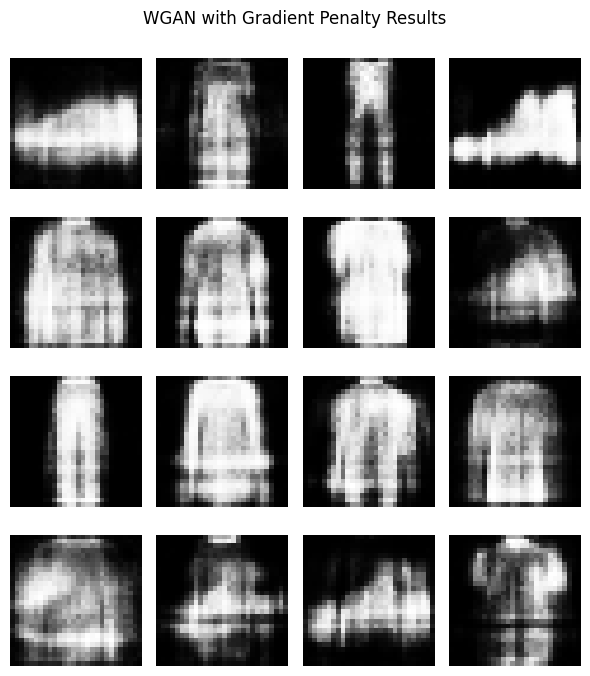

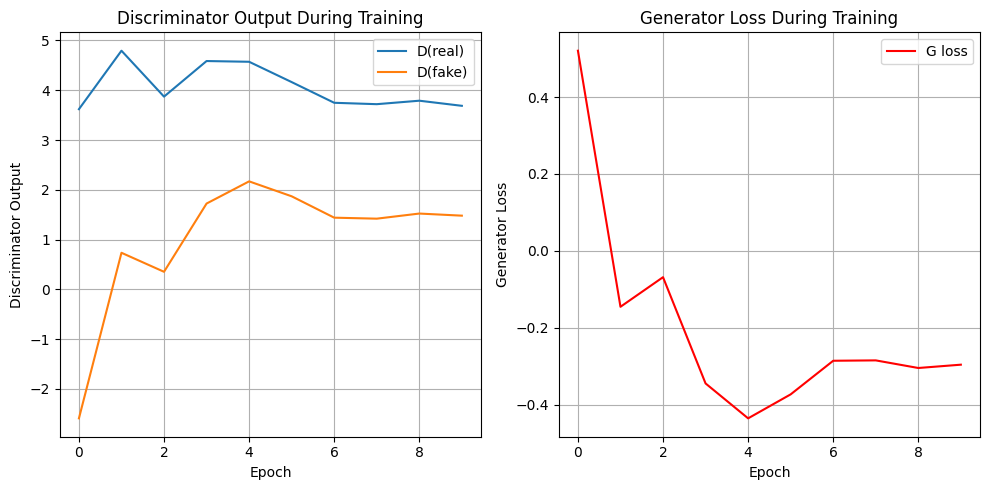

In [34]:
# визуализация результатов
noise.data.normal_(0, 1)
fake = generator_2(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.suptitle('WGAN with Gradient Penalty Results')
plt.tight_layout()
plt.show()

# График loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ERRD_real_2 / N, label='D(real)')
plt.plot(ERRD_fake_2 / N, label='D(fake)')
plt.xlabel('Epoch')
plt.ylabel('Discriminator Output')
plt.title('Discriminator Output During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ERRG_2 / N, label='G loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss During Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Что было сделано:

Weight clipping был заменён на gradient penalty (WGAN-GP).
Добавлен дополнительный loss-компонент, штрафующий дискриминатор за отклонение нормы градиента от 1.

#### Результаты:

Обучение стало более стабильным.

Качество сгенерированных изображений улучшилось: они стали чётче, лучше передают текстуры и формы.

#### Выводы:

Gradient penalty работает лучше weight clipping — обучение устойчивее, картинки качественнее.

#### Решение задания 3

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [52]:
class Config:
    pass

config_3 = Config()
config_3.mnist_path = None
config_3.batch_size = 16
config_3.num_workers = 3
config_3.num_epochs = 10
config_3.noise_size = 50
config_3.print_freq = 100
config_3.num_classes = 10  # 10 классов для FashionMNIST
config_3.lambda_gp = 10
config_3.n_critic = 5

In [53]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(train, batch_size=config_3.batch_size, shuffle=True)

In [54]:
# получение и распечатка всех классов
classes = train.classes
print("\nFashionMNIST classes:")
for i, class_name in enumerate(classes):
    print(f"{i}: {class_name}")


FashionMNIST classes:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


In [55]:
# классы FashionMNIST для условной генерации
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [56]:
class ConditionalGenerator(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalGenerator, self).__init__()

        self.num_classes = num_classes
        # embedding для меток
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential( 
            nn.Linear(config_3.noise_size + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, noise, labels):
        # прел/образование меток в embedding
        label_embedding = self.label_emb(labels)
        # конкатенация noise и label embedding
        x = torch.cat([noise, label_embedding], dim=1)
        return self.model(x)
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalDiscriminator, self).__init__()

        self.num_classes = num_classes
        # embedding для меток
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(28*28 + num_classes, 200),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(200, 50),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(50, 1))

    def forward(self, x, labels):
        # преобраззование меткок в embedding
        label_embedding = self.label_emb(labels)
        # выравнивание изображения, если нужно
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        # конкатенация image и label embedding
        x = torch.cat([x, label_embedding], dim=1)
        return self.model(x)

In [57]:
generator_3 = ConditionalGenerator(config_3.num_classes)
discriminator_3 = ConditionalDiscriminator(config_3.num_classes)

In [58]:
optim_G = optim.Adam(generator_3.parameters(), lr=0.0001)
optim_D = optim.Adam(discriminator_3.parameters(), lr=0.0001)

In [59]:
noise = Variable(torch.FloatTensor(config_3.batch_size, config_3.noise_size))
fixed_noise = Variable(torch.FloatTensor(config_3.batch_size, config_3.noise_size).normal_(0, 1))
# фиксированные метки для визуализации
fixed_labels = torch.randint(0, config_3.num_classes, (config_3.batch_size,))

In [60]:
# для вычисления gradient penalty (с учетом меток)
def compute_gradient_penalty(discriminator_3, real_samples, fake_samples, real_labels, fake_labels):
    # cлучайный вес для интерполяции
    alpha = torch.rand(real_samples.size(0), 1)
    alpha = alpha.expand(real_samples.size())
    
    # интерполяция между реальными и сгенерированными samples
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated_labels = real_labels
    
    d_interpolated = discriminator_3(interpolated,interpolated_labels)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients_norm = gradients.norm(2, dim=1)
    
    # gradient penalty = (||grad||_2 - 1)^2
    gradient_penalty = ((gradients_norm - 1) ** 2).mean()
    
    return gradient_penalty

In [61]:
# для хранения значений loss
ERRD_real_3 = np.zeros(config_3.num_epochs)
ERRD_fake_3 = np.zeros(config_3.num_epochs)
ERRG_3 = np.zeros(config_3.num_epochs)
N = len(dataloader)

for epoch in range(config_3.num_epochs):
    for iteration, (images, labels) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize L = E[D(fake)] - E[D(real)]
        #######
        
        # преобразование меткок в LongTensor
        labels = labels.long()

        discriminator_3.zero_grad()
        
        # реальные изображения
        real_data = images.view(images.shape[0], -1)
        
        # forward pass реальных изображений
        D_real = discriminator_3(real_data, labels)
        
        # генерируются фейковые изображения
        noise.data.normal_(0, 1)
        fake = generator_3(noise, labels)

        # forward pass фейковых изображений
        D_fake = discriminator_3(fake.detach(), labels)
        
        gradient_penalty = compute_gradient_penalty(discriminator_3, real_data.data, fake.data, labels, labels)
        
        # loss дискриминатора для WGAN: L = E[D(fake)] - E[D(real)] + lambda * GP
        errD = torch.mean(D_fake) - torch.mean(D_real) + config_3.lambda_gp * gradient_penalty
        ERRD_fake_3[epoch] += torch.mean(D_fake).item()
        ERRD_real_3[epoch] += torch.mean(D_real).item()
        
        errD.backward()
        
        # обновление весов дискриминатора
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######

        # обновление генератора каждые n_critic шагов
        if iteration % config_3.n_critic == 0:
            generator_3.zero_grad()
            
            # генерация новых фейковых изображений
            noise.data.normal_(0, 1)
            fake = generator_3(noise, labels)
            
            # forward pass фейков через дискриминатор
            D_fake = discriminator_3(fake, labels)
            
            # loss генератора для WGAN: -E[D(fake)] 
            errG = -torch.mean(D_fake)
            ERRG_3[epoch] += errG.item()
            
            errG.backward()
            
            # обновление весов генератора
            optim_G.step()
        
        # вывод статистики
        if (iteration+1) % config_3.print_freq == 0:
            print(f'Epoch: {epoch+1}/{config_3.num_epochs} '
                  f'Iter: {iteration+1} '
                  f'D_loss: {errD.item():.4f} '
                  f'G_loss: {errG.item() if "errG" in locals() else 0:.4f} '
                  f'GP: {gradient_penalty.item():.4f} '
                  f'D(real): {torch.mean(D_real).item():.4f} '
                  f'D(fake): {torch.mean(D_fake).item():.4f}')

Epoch: 1/10 Iter: 100 D_loss: -6.5988 G_loss: 6.2408 GP: 0.0847 D(real): 1.0245 D(fake): -6.4212
Epoch: 1/10 Iter: 200 D_loss: -8.2497 G_loss: 12.7309 GP: 0.1355 D(real): -3.0612 D(fake): -12.6659
Epoch: 1/10 Iter: 300 D_loss: -7.3478 G_loss: 12.6072 GP: 0.1164 D(real): -3.8604 D(fake): -12.3724
Epoch: 1/10 Iter: 400 D_loss: -8.0941 G_loss: 10.8640 GP: 0.1017 D(real): -1.6281 D(fake): -10.7389
Epoch: 1/10 Iter: 500 D_loss: -6.7933 G_loss: 8.2451 GP: 0.0804 D(real): -0.7787 D(fake): -8.3759
Epoch: 1/10 Iter: 600 D_loss: -7.6981 G_loss: 8.0817 GP: 0.0708 D(real): 0.2556 D(fake): -8.1503
Epoch: 1/10 Iter: 700 D_loss: -6.3272 G_loss: 7.0851 GP: 0.0813 D(real): 0.0779 D(fake): -7.0628
Epoch: 1/10 Iter: 800 D_loss: -5.5567 G_loss: 5.6601 GP: 0.0581 D(real): 0.7580 D(fake): -5.3799
Epoch: 1/10 Iter: 900 D_loss: -5.4234 G_loss: 4.7039 GP: 0.0655 D(real): 1.4764 D(fake): -4.6024
Epoch: 1/10 Iter: 1000 D_loss: -5.7788 G_loss: 3.9747 GP: 0.0635 D(real): 2.2760 D(fake): -4.1383
Epoch: 1/10 Iter: 1

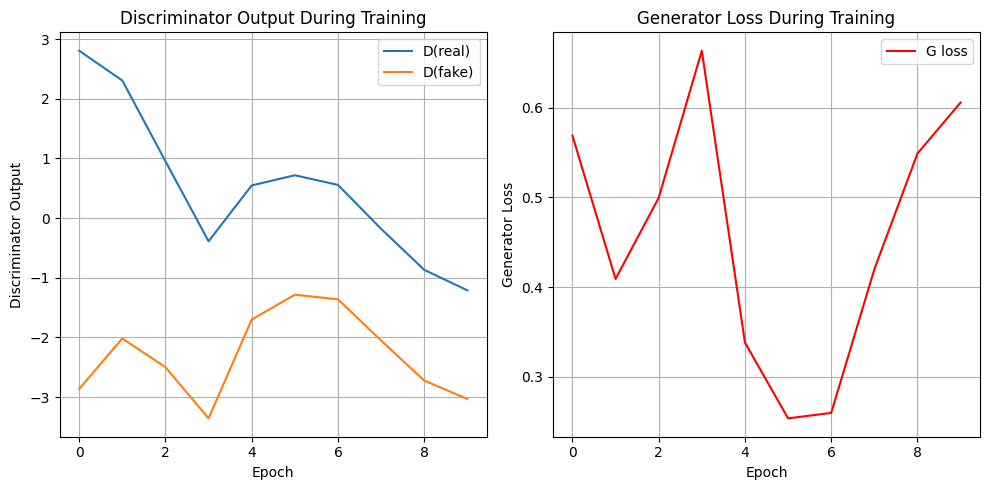

In [62]:
# визуализация результатов

# График loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ERRD_real_3 / N, label='D(real)')
plt.plot(ERRD_fake_3 / N, label='D(fake)')
plt.xlabel('Epoch')
plt.ylabel('Discriminator Output')
plt.title('Discriminator Output During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ERRG_3 / N, label='G loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss During Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

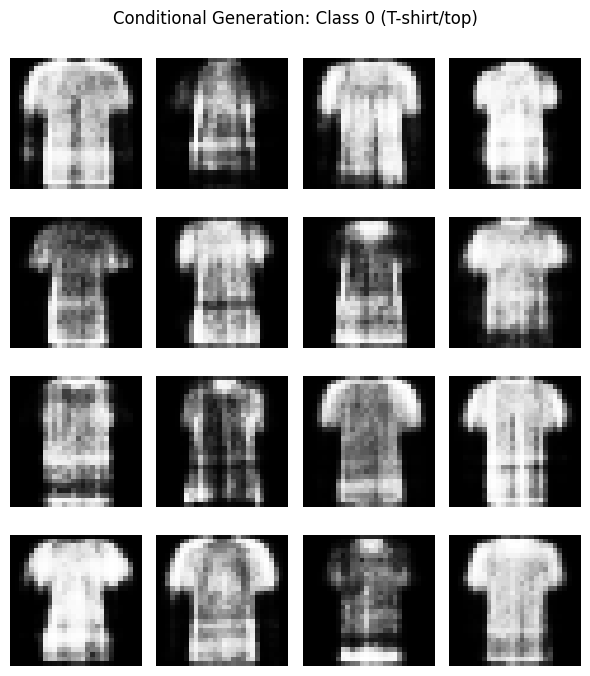

In [64]:
# генерация изображений одного класса
noise.data.normal_(0, 1)
target_labels = torch.zeros(config_3.batch_size, dtype=torch.long)
generated_images = generator_3(noise, target_labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.suptitle(f'Conditional Generation: Class 0 ({fashion_classes[0]})')
plt.tight_layout()
plt.show()

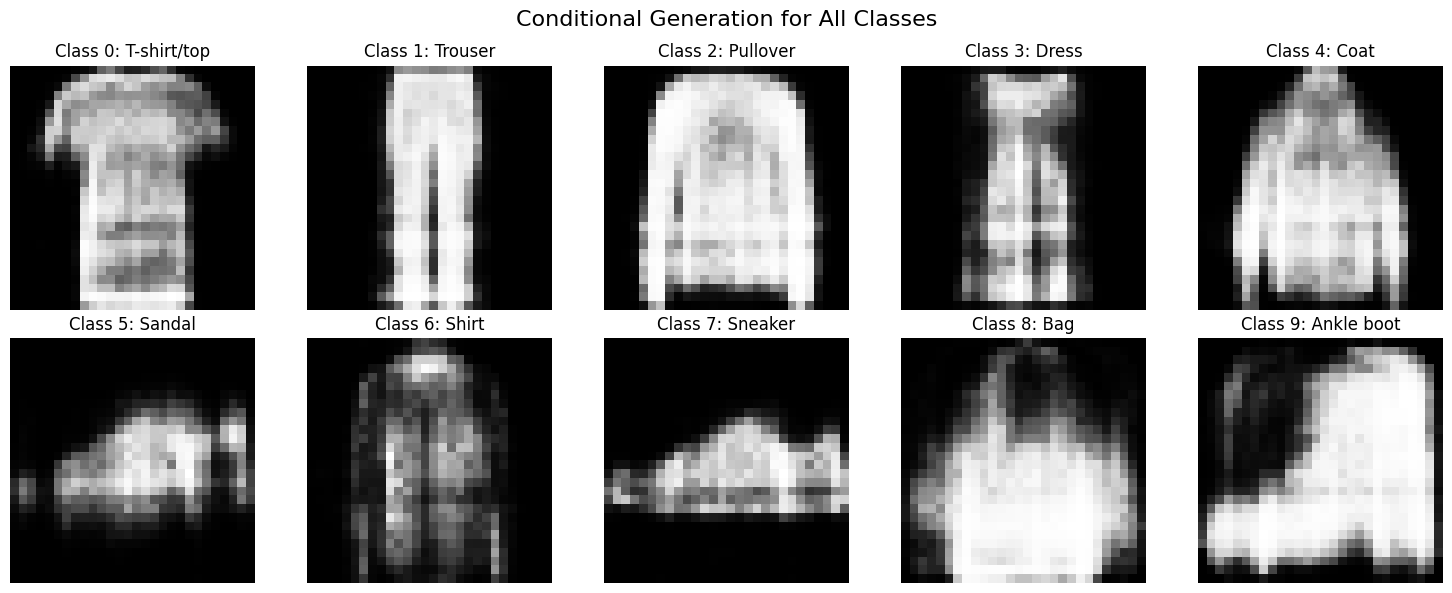

In [65]:
# генерация изображений по всем классам (сетка)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Conditional Generation for All Classes', fontsize=16)

for class_idx in range(config_3.num_classes):
    noise.data.normal_(0, 1)
    target_labels = torch.full((1,), class_idx, dtype=torch.long)
    generated_image = generator_3(noise[:1], target_labels)
    
    row = class_idx // 5
    col = class_idx % 5
    
    axes[row, col].imshow(generated_image[0].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    axes[row, col].set_title(f'Class {class_idx}: {fashion_classes[class_idx]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

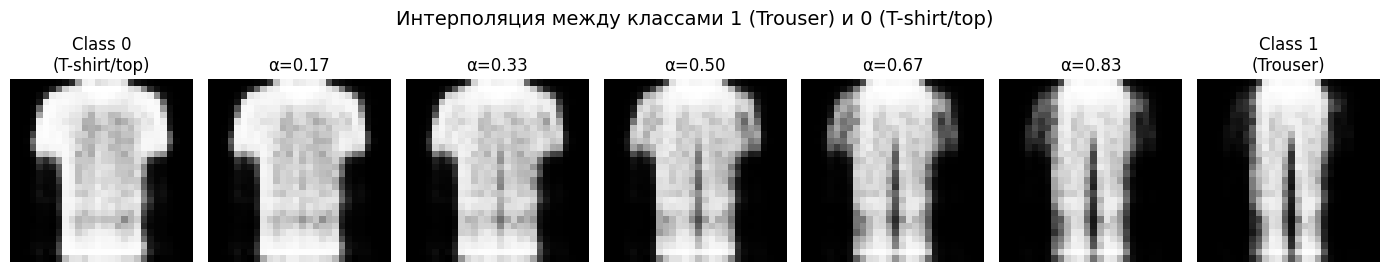

In [82]:
with torch.no_grad():
    # получение embedding векторов
    label_0 = torch.tensor([0], dtype=torch.long)
    label_1 = torch.tensor([1], dtype=torch.long)
    
    emb_0 = generator_3.label_emb(label_0)
    emb_1 = generator_3.label_emb(label_1)
    
    # генерация изображений с плавной интерполяцией в embedding пространстве
    num_steps = 7
    noise.data.normal_(0, 1)
    fixed_z_single = noise[0:1]  # один шумовой вектор
    
    plt.figure(figsize=(14, 3))
    
    for step in range(num_steps):
        # коэффициент интерполяции
        alpha = step / (num_steps - 1)
        
        # интерполяция embedding
        interp_emb = (1 - alpha) * emb_0 + alpha * emb_1
        
        # искусственная метка
        dummy_label = torch.tensor([0], dtype=torch.long)
        
        # получение embedding-а
        label_embedding = generator_3.label_emb(dummy_label)
        
        # замена на интерполированный embedding
        label_embedding = interp_emb
        
        # конкатенация и прогон через модель
        x = torch.cat([fixed_z_single, label_embedding], dim=1)
        generated_image = generator_3.model(x)
        
        # визуализация
        plt.subplot(1, num_steps, step + 1)
        plt.imshow(generated_image[0].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        
        if step == 0:
            plt.title(f'Class 0\n({fashion_classes[0]})')
        elif step == num_steps - 1:
            plt.title(f'Class 1\n({fashion_classes[1]})')
        else:
            plt.title(f'α={alpha:.2f}')
        
        plt.axis('off')

plt.suptitle('Интерполяция между классами 1 (Trouser) и 0 (T-shirt/top)', fontsize=14)
plt.tight_layout()
plt.show()

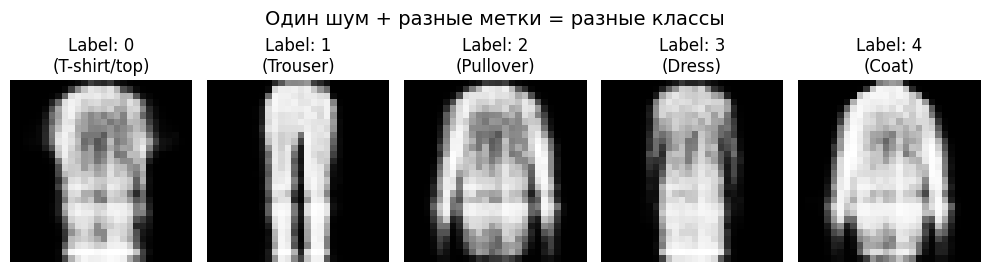

In [79]:
noise.data.normal_(0, 1)
same_noise = noise[0:1].repeat(5, 1)  # один и тот же шум 5 раз

labels_simple = torch.tensor([0, 1, 2, 3, 4], dtype=torch.long)

generated_simple = generator_3(same_noise[:5], labels_simple)

plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(generated_simple[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    class_idx = labels_simple[i].item()
    plt.title(f'Label: {class_idx}\n({fashion_classes[class_idx]})')
    plt.axis('off')

plt.suptitle('Один шум + разные метки = разные классы', fontsize=14)
plt.tight_layout()
plt.show()

#### Что было сделано:

В архитектуру добавлен условный механизм (Conditional GAN), где и генератор, и дискриминатор получают на вход метки классов (0–9 для FashionMNIST). Это позволяет управлять тем, какой класс объектов генерируется. Была опробована интерполяция между классами, что дало интересный результат.

#### Результаты:

Генератор научился создавать изображения заданных классов.

Визуально сгенерированные изображения лучше соответствуют целевым классам.

#### Выводы:

Условная генерация позволяет:

1) Контролировать выход модели.

2) Улучшить качество генерации за счёт дополнительной информации.

3) Ускорить обучение, так как модель лучше "понимает" структуру данных.